In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import Image

## Rear Axel Bicycle Model

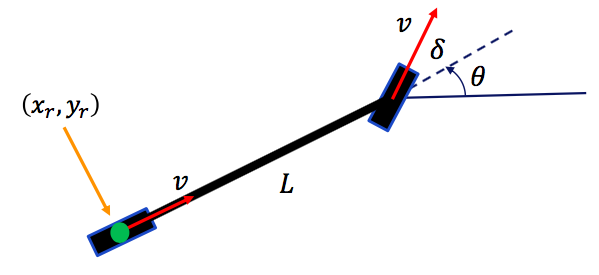

In [2]:
Image('rear_axle_bicycle_model.png', width=400)

### Transformation Class : Transformation for Visualization

In [3]:
class Transformation():
    # Transformation for drawing two wheels
    def convert_se2(self, p, theta):
        p = np.array(p)[:,None]
        c, s = np.cos(theta), np.sin(theta)
        R = np.array([[c,-s],[s,c]])
        return np.block([[R, p],[np.zeros((1,2)), 1]])

    def invert_se2(self, T):
        theta = np.arctan2(T[1,0], T[0,0])
        p = T[:2, -1]
        return p, theta

In [4]:
class BicycleModel():
    L = 2
    T = 0.1
    def bicycle_model(self, state, v, gamma):
        #state : x, y, theta
        x, y, theta = state
        delta = np.array([v*np.cos(theta), v*np.sin(theta), v/self.L*np.tan(gamma)]) * self.T
        return state + delta

### Bicycle Class : Transformation + BicycleModel + Visualization

In [5]:
class Bicycle(Transformation, BicycleModel):
    wheel_len = 1
    wheel_width = 0.5
    
    def set_state(self, state, gamma):
        self.state = state
        self.gamma = gamma
    
    def show(self, ax=None):
        fig, ax = plt.subplots(figsize=[5,5])
        x, y, theta = state

        self.draw_wheel(state, fr='rear')
        self.draw_wheel(state, fr='front')

        plt.scatter(x, y, color='k')
        plt.axis([-10, 10, -10, 10])
        plt.grid()
    
    def draw_wheel(self, state, gamma=0, fr='rear'):
        ax = plt.gca()
        T_s_wheel = self.convert_se2(state[:2], state[2])
        if fr=='front':
            T_s_wheel = T_s_wheel @ self.convert_se2([self.L,0], 0) @ self.convert_se2([0,0], self.gamma)
        
        draw_pos = - np.array([self.wheel_len, self.wheel_width])/2
        T_wheel_draw = self.convert_se2(draw_pos[:2], 0)
        
        T_s_draw = T_s_wheel @ T_wheel_draw
        draw_xy, draw_theta = self.invert_se2(T_s_draw)
        wheel = patches.Rectangle(draw_xy, 
                                  self.wheel_len, self.wheel_width, 
                                  np.rad2deg(draw_theta), fc=None, ec='k', alpha=0.5)
        
        ax.add_patch(wheel)
        
        wheel_xy, wheel_theta = self.invert_se2(T_s_wheel)
        arrow_len = 1
        arrow_x, arrow_y = arrow_len * np.array([np.cos(wheel_theta), np.sin(wheel_theta)])
        ax.arrow(*wheel_xy, arrow_x, arrow_y, 
                 length_includes_head=True, head_width=0.3, head_length=0.5)
        

### Visualization 

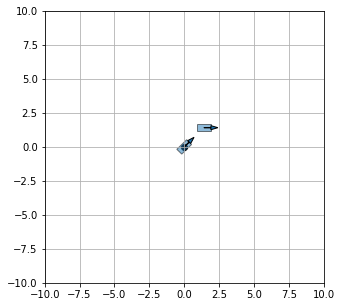

In [7]:
bicycle = Bicycle()
state = [0,0,np.pi/4]
gamma = -np.pi/4
bicycle.set_state(state,gamma)
bicycle.show()

### Simple simulation 

In [8]:
start = [0,0,0]
# fixed velocity, steering
v = 1
gamma = 0.5

In [9]:
states = ['x','y','theta']
sim = pd.DataFrame(columns=['time']+states)
sim['time'] = np.arange(0, 10, 0.1)
sim.loc[0,states] = start

In [10]:
curr_state = sim.loc[0,states]
for i, row in sim.iterrows():
    next_state = bicycle.bicycle_model(curr_state, v, gamma)
        
    if i < len(sim)-1:
        sim.loc[i+1,states] = next_state
        sim.loc[i+1, 'v'] = v
        sim.loc[i+1, 'gamma'] = gamma
    
    curr_state = next_state
sim

,time,x,y,theta,v,gamma
0,0.0,0,0,0,NaN,NaN
1,0.1,0.1,0,0.0273151,1.0,0.5
2,0.2,0.199963,0.00273117,0.0546302,1.0,0.5
3,0.3,0.299814,0.00819148,0.0819454,1.0,0.5
4,0.4,0.399478,0.0163769,0.10926,1.0,0.5
...,...,...,...,...,...,...
95,9.5,1.99569,6.76201,2.59494,1.0,0.5
96,9.6,1.91027,6.814,2.62225,1.0,0.5
97,9.7,1.82345,6.86363,2.64957,1.0,0.5
98,9.8,1.73531,6.91087,2.67688,1.0,0.5


### Result 

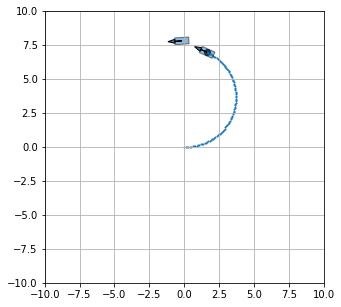

In [12]:
state = sim.loc[len(sim)-1, ['x','y','theta']].tolist()
gamma = sim.loc[len(sim)-1, ['gamma']][0]
bicycle.set_state(state, gamma)
bicycle.show();
plt.scatter(sim.loc[:i,'x'], sim.loc[:i,'y'], s=1);

### draw animation 

In [13]:
from PIL import Image as PILImage
import io
def make_snapshot(close=True):
    fig = plt.gcf()
    buffer = io.BytesIO()        
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    im = PILImage.open(buffer)
    if close==True:
        plt.close()
    return im

In [16]:
ims = []
for i, row in sim.iterrows():
    state = row.loc[['x','y','theta']].to_numpy()
    gamma = row.loc['gamma']
    bicycle.set_state(state, gamma)
    bicycle.show();
    plt.scatter(sim.loc[:i,'x'], sim.loc[:i,'y'], s=1)
    
    ims.append(make_snapshot())

In [17]:
ims[0].save('out.gif', format='GIF',append_images=ims[1:], save_all=True, duration=100, loop=0)

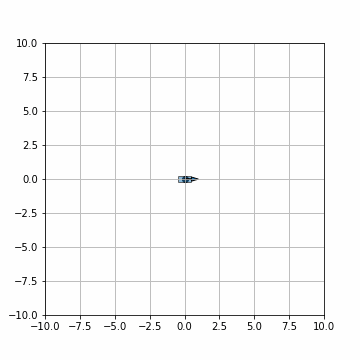

In [18]:
Image('out.gif', width=400)